In [1]:

# 用于生成 Figure 2: (a) 效率对比 vs (b) 超参数影响
import multiprocessing
import time
from functools import partial

import matplotlib.pyplot as plt
# In[1]:
# =============================================================================
# --- 1. 导入和设置 (Imports and Setup) ---
# =============================================================================
import numpy as np
import qutip as qt

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# 从我们创建的模块中导入函数
# 修改模块导入路径
from cspsa2 import run_instrumental_cspsa_simulation, run_chsh_cspsa_simulation
from sga2 import run_instrumental_sga_simulation, run_chsh_sga_simulation

In [2]:

# =============================================================================
# --- 2. 状态生成函数 (State Generation Functions) ---
# =============================================================================
# The simpler way to get the state vector for the |Φ+> Bell state
# Convert to a density matrix
ket0, ket1 = qt.basis(2, 0), qt.basis(2, 1)
psi_pure = 1/np.sqrt(2) * (qt.tensor(ket0, ket0) + qt.tensor(ket1, ket1))
mae_state = qt.ket2dm(psi_pure)
# 生成一个随机混合态
def generate_random_mixed_state():
    dm = qt.rand_dm(4, distribution='hs')
    dm.dims = [[2, 2], [2, 2]]
    return dm

rms1 = generate_random_mixed_state()
rms2 = generate_random_mixed_state()
rms3 = generate_random_mixed_state()
rms4 = generate_random_mixed_state()

In [3]:
# =============================================================================
# --- 3. ✅ 标准任务 配置: 具有最全面的可选项 ---
# =============================================================================
# 固定超参数，对比不同量子态
ALGORITHMS = {'CSPSA': run_instrumental_cspsa_simulation, 'SGA': run_instrumental_sga_simulation}
HPARAMS = {
    'fixed': {
        'cspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'sga': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0}
    }
}
STATES = {
     "Maximally Entangled State": mae_state,
    "Random Mixed 1": generate_random_mixed_state(),
}
PHOTON_NUMs = {'unlimited': 1e9, 'few': 100, 'many': 200}
STATES_VARIATIONS = {'low': np.pi/50,  'middle': np.pi/40, 'high': np.pi/30}
MEASUREMENT_UNCERTAINTY = {'low': 0.1, 'middle': 0.2, 'high': 0.3}
CONFIG = {'iterations':200, 'num_repetitions': 1}

In [4]:
# =============================================================================
# --- 4a. ✅ 任务1a 配置: 效率对比 ---
# =============================================================================
# 固定超参数，对比不同量子态
ALGORITHMS_1a = {'CSPSA': run_chsh_cspsa_simulation, 'SGA': run_chsh_sga_simulation}
HPARAMS_1a = {
    'default': {
        'cspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'sga': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0}
    }
}
STATES_1a = {
    "MES": mae_state,
    "RMS 1": rms1,
    "RMS 2": rms2,
    "RMS 3": rms3,
    "RMS 4": rms4,
}
PHOTON_NUMs_1a = {'unlimited': 1e15}
#QUANTUM_TESTs_1a = {'Instrumental': 0}
STATES_VARIATIONS_1a = {"zero": 0}
MEASUREMENT_UNCERTAINTY_1a = {"zero": 0}
CONFIG_1a = {'iterations':1000, 'num_repetitions': 30}

In [5]:
# =============================================================================
# --- 4b. ✅ 任务1b 配置: 效率对比 ---
# =============================================================================
# 固定超参数，对比不同量子态
ALGORITHMS_1b = {'CSPSA': run_instrumental_cspsa_simulation, 'SGA': run_instrumental_sga_simulation}
HPARAMS_1b = {
    'default': {
        'cspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'sga': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0}
    }
}
STATES_1b = {
    "MES": mae_state,
    "RMS 1": rms1,
    "RMS 2": rms2,
    "RMS 3": rms3,
    "RMS 4": rms4,
}
PHOTON_NUMs_1b = {'unlimited': 1e15}
#QUANTUM_TESTs_1b = {'Instrumental': 0}
STATES_VARIATIONS_1b = {"zero": 0}
MEASUREMENT_UNCERTAINTY_1b = {"zero": 0}
CONFIG_1b = {'iterations':1000, 'num_repetitions': 30}

In [6]:

# =============================================================================
# --- 5. 实验执行循环 (Run Simulations) ---
# =============================================================================
def run_simulations(task_name, algorithms, hparams, states,photon_nums,state_variations,uncertainties, config):
    all_results = []
    print(f"\n>>>>>> STARTING TASK: {task_name} <<<<<<")
    start_time = time.time()
    for hparam_name, hparam_values in hparams.items():
        for state_name, state_rho in states.items():
            for photon_num_name, photon_num_values in photon_nums.items():
                for state_variation_name, state_variation_values in state_variations.items():
                    for uncertainty_name, uncertainty_values in uncertainties.items():
                        for algo_name in algorithms:
                            print(f"...Running: [Algo: {algo_name}] |[Uncertainty: {uncertainty_name}]| [state_variation: {state_variation_name}]|[photon used: {photon_num_name}]|[State: {state_name}] | [Hparam: {hparam_name}]...")
                            current_config = {'state': state_rho, 'hparams': hparam_values, 'photon_num':photon_num_values,'state_variation':state_variation_values,'uncertainty':uncertainty_values,**config}

                            # CORRECT INDENTATION: The following block has been moved inside the `for algo_name...` loop.
                            worker_function = partial(algorithms[algo_name], current_config)
                            with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                                histories = pool.map(worker_function, range(config['num_repetitions']))
                            mean_history = np.mean(np.abs(histories), axis=0)
                            all_results.append({
                                'hparam_set': hparam_name,
                                'state_name': state_name,
                                'photon_num_name': photon_num_name,
                                'state_variation_name': state_variation_name,
                                'uncertainty_name': uncertainty_name,
                                'algo_name': algo_name,
                                'mean_history': mean_history
                            })
    end_time = time.time()
    print(f">>>>>> TASK {task_name} COMPLETE IN {end_time - start_time:.2f} s <<<<<<\n")
    return all_results

if __name__ == '__main__':
    results_1a = run_simulations("1a: States", ALGORITHMS_1a, HPARAMS_1a, STATES_1a,PHOTON_NUMs_1a,STATES_VARIATIONS_1a,MEASUREMENT_UNCERTAINTY_1a, CONFIG_1a)
results_1b = run_simulations("1b: Hyperparameters", ALGORITHMS_1b, HPARAMS_1b, STATES_1b, PHOTON_NUMs_1b,STATES_VARIATIONS_1b,MEASUREMENT_UNCERTAINTY_1b, CONFIG_1b)



>>>>>> STARTING TASK: 1a: States <<<<<<
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: unlimited]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: SGA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: unlimited]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: unlimited]|[State: RMS 1] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: SGA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: unlimited]|[State: RMS 1] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: unlimited]|[State: RMS 2] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: SGA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: unlimited]|[State: RMS 2] | [Hparam: defaul

Generating Figure 2...


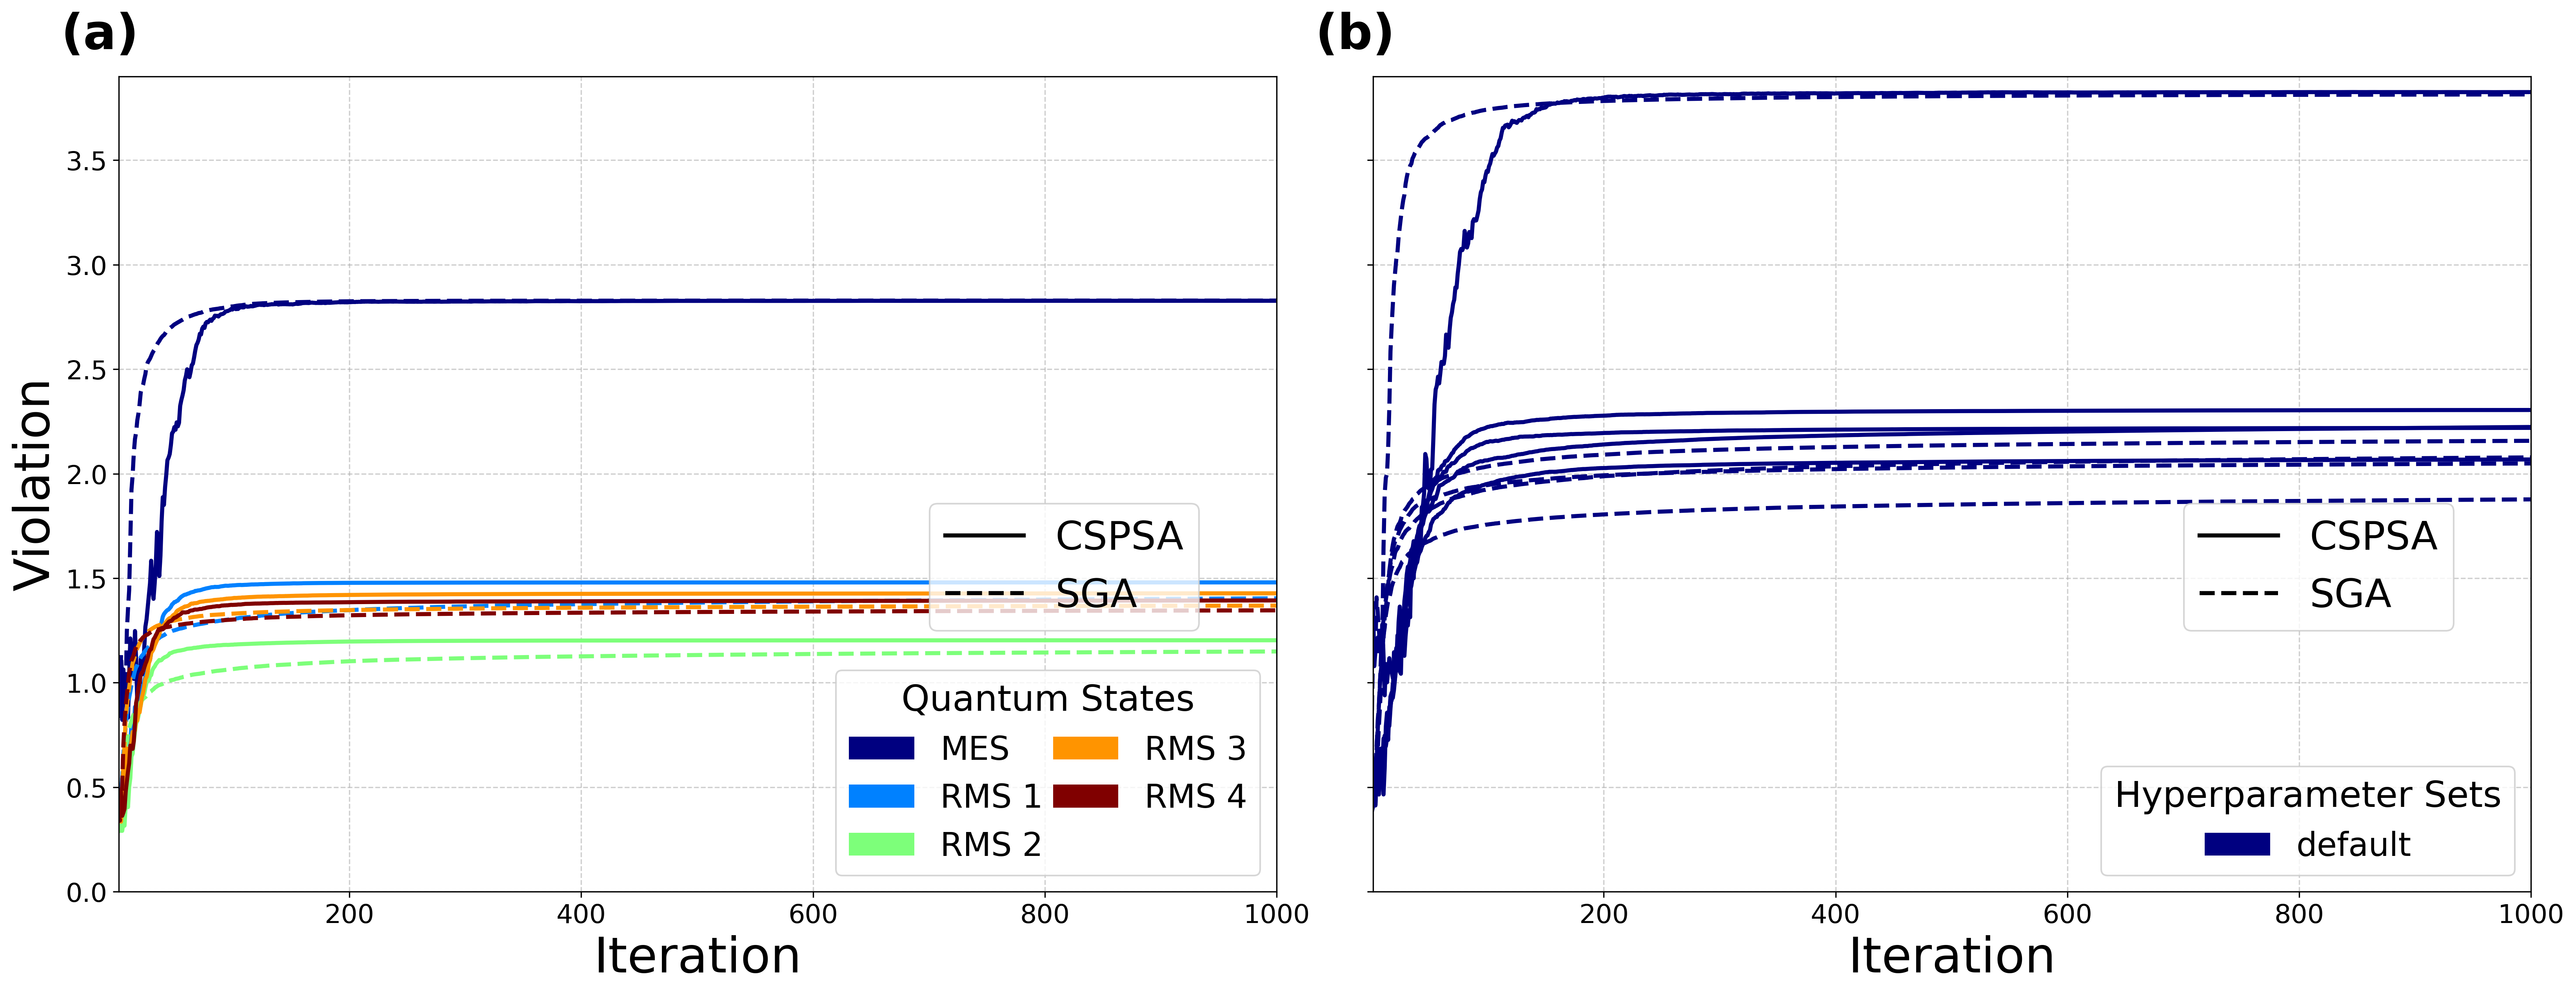

In [7]:
    # =============================================================================
# --- 6. 绘图 (Plotting Figure 2) ---
# =============================================================================
print("Generating Figure 2...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9), sharey=True, dpi=300)
plt.style.use('default') # 保持您满意的风格

# --- 图(a): 效率对比 ---
colors_1a = plt.cm.jet(np.linspace(0, 1, len(STATES_1a)))
state_colors = {name: colors_1a[i] for i, name in enumerate(STATES_1a.keys())}
algo_lines = {'CSPSA': '-', 'SGA': '--'}

for r in results_1a:
   ax1.plot(r['mean_history'],
             color=state_colors[r['state_name']],
             linestyle=algo_lines[r['algo_name']],
             linewidth=2.5)

ax1.text(-0.05, 1.08, '(a)', transform=ax1.transAxes, fontsize=30, fontweight='bold', va='top')

# 图例 (a)
leg_states = [Patch(facecolor=state_colors[name], label=name) for name in STATES_1a.keys()]
leg_algos = [Line2D([0], [0], color='black', lw=2.5, linestyle=ls, label=name) for name, ls in algo_lines.items()]
legend1 = ax1.legend(handles=leg_states, loc='lower right', title='Quantum States', ncol=2, columnspacing=0.3, fontsize=20, title_fontsize=22)
ax1.add_artist(legend1)
ax1.legend(handles=leg_algos, loc='upper right', bbox_to_anchor=(0.95, 0.500), fontsize=24)
# --- 新增代码: 设置a图的x轴范围 ---
ax1.set_xlim(1, 1000)
# --- 图(b): 超参数影响 ---
colors_1b = plt.cm.jet(np.linspace(0, 1, len(HPARAMS_1b)))
hparam_colors = {name: colors_1b[i] for i, name in enumerate(HPARAMS_1b.keys())}

for r in results_1b:
   ax2.plot(r['mean_history'],
             color=hparam_colors[r['hparam_set']],
             linestyle=algo_lines[r['algo_name']],
             linewidth=2.5)

ax2.text(-0.05, 1.08, '(b)', transform=ax2.transAxes, fontsize=30, fontweight='bold', va='top')

# 图例 (b)
leg_hparams = [Patch(facecolor=hparam_colors[name], label=name) for name in HPARAMS_1b.keys()]
legend2 = ax2.legend(handles=leg_hparams, loc='lower right', ncol=5 , columnspacing=0.3 ,title='Hyperparameter Sets', fontsize=20, title_fontsize=22)
ax2.add_artist(legend2)
ax2.legend(handles=leg_algos, loc='upper right', bbox_to_anchor=(0.95, 0.5), fontsize=24)
# --- 新增代码: 设置a图的x轴范围 ---
ax2.set_xlim(1, 1000)
# --- 全局设置 ---
for ax in [ax1, ax2]:
   ax.set_xlabel("Iteration", fontsize=30)
   ax.grid(True, linestyle='--', alpha=0.6)
   ax.set_ylim(bottom=0)
   ax.tick_params(axis='both', which='major', labelsize=16)

# --- Control the overall shared y-axis range ---
# Setting the y-limit on one shared axis applies to all.
# Set the desired maximum y-value for the Violation axis.
# Adjust this value (e.g., 3.0) higher or lower as needed.
overall_max_violation = 3.9 # <--- Set your desired max Y value here
ax1.set_ylim(top=overall_max_violation) # Apply the top limit to ax1 (which shares with ax2)
ax1.set_ylim(bottom=0) # Apply the top limit to ax1 (which shares with ax2)

ax1.set_ylabel("Violation", fontsize=30)
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("figure2_instrumental_analysis.pdf", format='pdf', bbox_inches='tight')
plt.show()

